In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
data = pd.read_csv('/kaggle/input/phishingemails/Phishing_Email.csv',index_col=[0])

In [15]:
data.shape

(18650, 2)

In [8]:
data.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [9]:
data.isnull().sum()

Email Text    16
Email Type     0
dtype: int64

In [10]:
data['Email Type'].unique()

array(['Safe Email', 'Phishing Email'], dtype=object)

<Axes: >

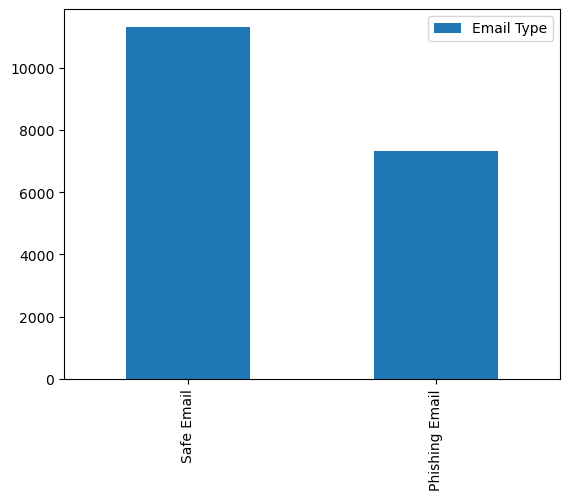

In [14]:
data['Email Type'].value_counts().plot(kind='bar',legend=True)

In [18]:
corpus = []
for text in data['Email Text']:
    email = re.sub('[^a-zA-Z]', ' ', str(text))
    email = email.lower()
    email = email.split()
    stemmer = PorterStemmer() #stemming
    email = [stemmer.stem(word) for word in email if word not in set(stop_words)]
    email = ' '.join(email)
    corpus.append(email)

In [20]:
cv = CountVectorizer(max_features = 10000)
X = cv.fit_transform(corpus).toarray()
y = data.iloc[:, -1].values

In [21]:
# Train and test data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

In [23]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [26]:
init_models = {
    'gaussian':GaussianNB(),
    'multinomial':MultinomialNB(force_alpha=True),
    'compliment':ComplementNB(force_alpha=True),
    'bernaulli':BernoulliNB(force_alpha=True)
}

for key in init_models.keys():
    print('-'*20)
    print(f'Using : {key}')
    clf = init_models.get(key)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion matrix for : {key}\n{cm}")
    print(f"Accuracy score for : {key}\n{accuracy_score(y_test, y_pred)}")
    print('-'*20)

--------------------
Using : gaussian
Confusion matrix for : gaussian
[[1391  105]
 [ 403 1831]]
Accuracy score for : gaussian
0.8638069705093834
--------------------
--------------------
Using : multinomial
Confusion matrix for : multinomial
[[1406   90]
 [  90 2144]]
Accuracy score for : multinomial
0.9517426273458445
--------------------
--------------------
Using : compliment
Confusion matrix for : compliment
[[1416   80]
 [  99 2135]]
Accuracy score for : compliment
0.9520107238605898
--------------------
--------------------
Using : bernaulli
Confusion matrix for : bernaulli
[[1450   46]
 [ 358 1876]]
Accuracy score for : bernaulli
0.8916890080428954
--------------------


In [30]:
# ComplimentNB seems to perform the best hence going with that model,

from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],         # Laplace smoothing parameter
    'fit_prior': [True, False],       # Whether to learn class prior probabilities or not
    'force_alpha':[True,False]
}

model = ComplementNB()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validated score: ", grid_search.best_score_)

params = grid_search.best_params_

Best hyperparameters:  {'alpha': 0.1, 'fit_prior': True, 'force_alpha': True}
Best mean cross-validated score:  0.9460589812332438


In [36]:
final_model = ComplementNB(
    alpha = 0.1,
    fit_prior = True,
    force_alpha = True
)

final_model.fit(X_train, y_train)

ComplementNB(alpha=0.1, force_alpha=True)

Hope this notebook helped you, thank you for reading.
Please up-vote if this helped.